In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
import torch

from raimitigations.utils import train_model_plot_results, split_data
import raimitigations.dataprocessing as dp

# Case Study 3

## Fixing a seed

To avoid randomness in the following experiments, we'll fix the seeds to guarantee that the results obtained are the same each time we run this notebook. Feel free to comment the next cell or test different seeds to see how this affects the results.

In [2]:
import random
SEED = 45
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## 1 - Understanding the Data

Case study 3 examines the thyroid disease dataset. We will explore how this dataset with the `dataprocessing` library.

In [3]:
df = database.load_thyroid_disease()
label_col = "sick-euthyroid"
df

,sick-euthyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,sick-euthyroid,72.0,M,f,f,f,f,f,f,f,...,y,1.0,y,83.0,y,0.95,y,87.0,n,NaN
1,sick-euthyroid,45.0,F,f,f,f,f,f,f,f,...,y,1.0,y,82.0,y,0.73,y,112.0,n,NaN
2,sick-euthyroid,64.0,F,f,f,f,f,f,f,f,...,y,1.0,y,101.0,y,0.82,y,123.0,n,NaN
3,sick-euthyroid,56.0,M,f,f,f,f,f,f,f,...,y,0.8,y,76.0,y,0.77,y,99.0,n,NaN
4,sick-euthyroid,78.0,F,t,f,f,f,t,f,f,...,y,0.3,y,87.0,y,0.95,y,91.0,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,negative,40.0,F,f,f,f,f,f,f,f,...,y,1.2,y,76.0,y,0.90,y,84.0,n,NaN
3159,negative,69.0,F,f,f,f,f,f,f,f,...,y,1.8,y,126.0,y,1.02,y,124.0,n,NaN
3160,negative,58.0,F,f,f,f,f,f,f,f,...,y,1.7,y,86.0,y,0.91,y,95.0,n,NaN
3161,negative,29.0,F,f,f,f,f,f,f,f,...,y,1.8,y,99.0,y,1.01,y,98.0,n,NaN


In [4]:
df[label_col] = df[label_col].replace({"sick-euthyroid": 1, "negative": 0})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sick-euthyroid             3163 non-null   int64  
 1   age                        2717 non-null   float64
 2   sex                        3090 non-null   object 
 3   on_thyroxine               3163 non-null   object 
 4   query_on_thyroxine         3163 non-null   object 
 5   on_antithyroid_medication  3163 non-null   object 
 6   thyroid_surgery            3163 non-null   object 
 7   query_hypothyroid          3163 non-null   object 
 8   query_hyperthyroid         3163 non-null   object 
 9   pregnant                   3163 non-null   object 
 10  sick                       3163 non-null   object 
 11  tumor                      3163 non-null   object 
 12  lithium                    3163 non-null   object 
 13  goitre                     3163 non-null   objec

In [6]:
df['query_on_thyroxine'].value_counts()

f    3108
t      55
Name: query_on_thyroxine, dtype: int64

The dataset is imbalanced, as most patients in the dataset do not have thyroid disease.

In [7]:
counts = df['query_on_thyroxine'].value_counts().values
counts

array([3108,   55])

In [8]:
cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					json_summary="./corr_json/c3_summary.json",
					json_corr="./corr_json/c3_corr.json",
					json_uncorr="./corr_json/c3_uncorr.json"
				)
cor_feat.fit(df=df, label_col=label_col)

Remember to look through the JSON files generated in the previous cell. Correlations have been found, which can be seen in `c3_corr.json`.

## 2 - Basic Pre-Processing

### Encode Categorical Variables
The dataset contains a number of columns that are categorical. `EncoderOHE` is used to perform One Hot Encoding on the dataset.

In [9]:
# Encode the categorical columns using One-Hot Encoding
enc_ohe = dp.EncoderOHE()
enc_ohe.fit(df)
proc_df = enc_ohe.transform(df)
proc_df

No columns specified for encoding. These columns have been automatically identfied as the following:
['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured']


,sick-euthyroid,age,TSH,T3,TT4,T4U,FTI,TBG,sex_M,sex_nan,...,sick_t,tumor_t,lithium_t,goitre_t,TSH_measured_y,T3_measured_y,TT4_measured_y,T4U_measured_y,FTI_measured_y,TBG_measured_y
0,1,72.0,NaN,1.0,83.0,0.95,87.0,NaN,1,0,...,0,0,0,0,0,1,1,1,1,0
1,1,45.0,1.90,1.0,82.0,0.73,112.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
2,1,64.0,0.09,1.0,101.0,0.82,123.0,NaN,0,0,...,1,0,0,0,1,1,1,1,1,0
3,1,56.0,0.00,0.8,76.0,0.77,99.0,NaN,1,0,...,0,0,0,0,1,1,1,1,1,0
4,1,78.0,2.60,0.3,87.0,0.95,91.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,0,40.0,2.10,1.2,76.0,0.90,84.0,NaN,0,0,...,1,0,0,0,1,1,1,1,1,0
3159,0,69.0,2.60,1.8,126.0,1.02,124.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
3160,0,58.0,5.80,1.7,86.0,0.91,95.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
3161,0,29.0,0.80,1.8,99.0,1.01,98.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0


### Impute Missing Data

A number of features contain missing values. We will use `BasicImputer` to fill these values with -1

In [10]:
proc_df.isna().sum()

sick-euthyroid                    0
age                             446
TSH                             468
T3                              695
TT4                             249
T4U                             248
FTI                             247
TBG                            2903
sex_M                             0
sex_nan                           0
on_thyroxine_t                    0
query_on_thyroxine_t              0
on_antithyroid_medication_t       0
thyroid_surgery_t                 0
query_hypothyroid_t               0
query_hyperthyroid_t              0
pregnant_t                        0
sick_t                            0
tumor_t                           0
lithium_t                         0
goitre_t                          0
TSH_measured_y                    0
T3_measured_y                     0
TT4_measured_y                    0
T4U_measured_y                    0
FTI_measured_y                    0
TBG_measured_y                    0
dtype: int64

In [11]:
imputer = dp.BasicImputer(numerical={'missing_values':np.nan,
									'strategy':'constant',
									'fill_value':-1})
imputer.fit(proc_df)
proc_df = imputer.transform(proc_df)

No columns specified for imputation. These columns have been automatically identified:
['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']


### Split Dataset

In [12]:
train_x, test_x, train_y, test_y = split_data(proc_df, label_col, test_size=0.25)

## 2 - Baseline Models

In this example, we have an imbalanced dataset (most patients do not have thyroid disease). While we will take a look at a number of different metrics, we will be focused on improved the F1 score for this dataset.

After splitting the data into train and test sets, we will build two baseline models, one with XGBoost, and the other with KNN.

------------
TEST
------------
[[704  14]
 [  9  64]]


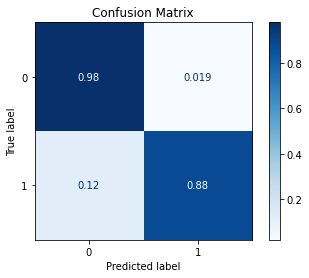

Acuracy: 97.09%

Precision:  0.9039450498076024

Recall:  0.9286068607623916

F1 =  0.9158047213776316

ROC AUC =  0.9617182432174611


In [13]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False, plot_pr=False)

------------
TEST
------------
[[536 182]
 [ 27  46]]


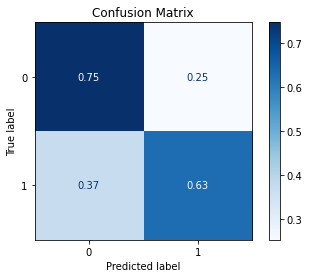

Acuracy: 73.58%

Precision:  0.5768985073696675

Recall:  0.6883275460754761

F1 =  0.5712470272134779

ROC AUC =  0.7110218643873774


In [14]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="knn", train_result=False, plot_pr=False)

## 3 - Data Transformation

We will perform a number of different feature transformations, using the Scalers from `dataprocessing`.

### DataMinMaxScaler

The first data transformation we will perform is a MinMaxScaler, which will scale each feature to have a range between zero and one

------------
TEST
------------
[[611 107]
 [ 13  60]]


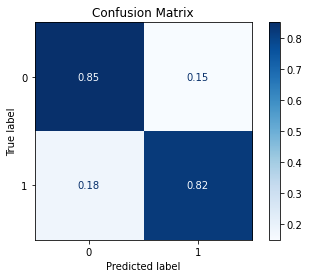

Acuracy: 84.83%

Precision:  0.6692240518962076

Recall:  0.8364463692906475

F1 =  0.7052906110283159

ROC AUC =  0.8665528293967262


In [15]:
scaler = dp.DataMinMaxScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataNormalizer

Next we try `DataNormalizer`, which will scale the vectors to have unit norm (i.e. vector of length one). This is often used in text classification, but we will use it here as well. 

No columns specified for imputation. These columns have been automatically identified:
[]
------------
TEST
------------
[[541 177]
 [ 26  47]]


/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


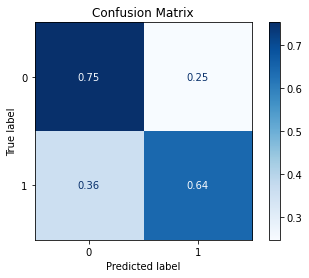

Acuracy: 74.34%

Precision:  0.581983024691358

Recall:  0.698658755294387

F1 =  0.5792608314009092

ROC AUC =  0.7177090090433853


In [16]:
scaler = dp.DataNormalizer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataQuantileTransformer

The Quantile Transformer transforms the each feature to have a normal distribution.

------------
TEST
------------
[[598 120]
 [  9  64]]


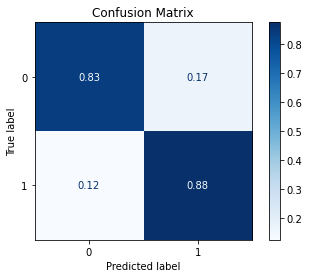

Acuracy: 83.69%

Precision:  0.6664995344173054

Recall:  0.8547907047735337

F1 =  0.7003479920710668

ROC AUC =  0.8824836875643911


In [17]:
scaler = dp.DataQuantileTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataRobustScaler

The robust scaler centers the data (median=zero) and scales the data based on the interquartile range (IQR).

------------
TEST
------------
[[611 107]
 [  9  64]]


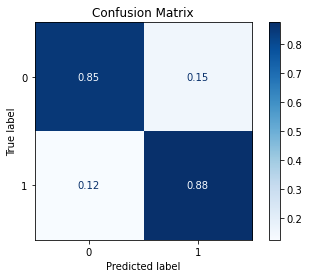

Acuracy: 85.34%

Precision:  0.6798764384078475

Recall:  0.8638436295646201

F1 =  0.7189468009507707

ROC AUC =  0.8919468081047048


In [18]:
scaler = dp.DataRobustScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataPowerTransformer

The power transformer makes the data more Gaussian-like (by default using the Yeo-Johnson transform).

------------
TEST
------------
[[590 128]
 [ 11  62]]


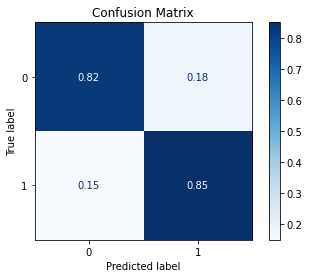

Acuracy: 82.43%

Precision:  0.654006480427358

Recall:  0.8355210439958789

F1 =  0.6830500119632053

ROC AUC =  0.8798221849124279


In [19]:
scaler = dp.DataPowerTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataStandardScaler

The standard scaler sets the mean to zero and scales the vectors to have unit variance.

------------
TEST
------------
[[605 113]
 [  8  65]]


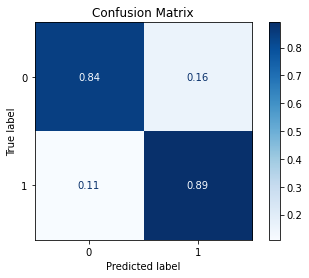

Acuracy: 84.70%

Precision:  0.6760589841816815

Recall:  0.866514671652612

F1 =  0.7135095979717494

ROC AUC =  0.9002842751936504


In [20]:
scaler = dp.DataStandardScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

From the previous results, we can see that the **DataStandardScaler** managed to get a considerable improvement over the baseline model. We'll use this scaled dataset in the following experiments.

## 4 - Feature Selection

Next, we perform a feature selection, which removes features from the dataset.

In [21]:
feat_sel = dp.CatBoostSelection(steps=5, verbose=False)
feat_sel.fit(X=train_x_scl, y=train_y)
train_x_sel = feat_sel.transform(train_x_scl)
test_x_sel = feat_sel.transform(test_x_scl)

In [22]:
feat_sel.get_selected_features()

['age',
 'TSH',
 'T3',
 'TT4',
 'FTI',
 'TBG',
 'sex_nan',
 'on_thyroxine_t',
 'on_antithyroid_medication_t',
 'thyroid_surgery_t',
 'query_hypothyroid_t',
 'query_hyperthyroid_t',
 'pregnant_t',
 'sick_t',
 'lithium_t',
 'goitre_t',
 'T3_measured_y']

We can see that we managed to remove a considerable amount of features from the dataset. Now, let's see if we manage to get any improvement in the metrics.

------------
TEST
------------
[[626  92]
 [  9  64]]


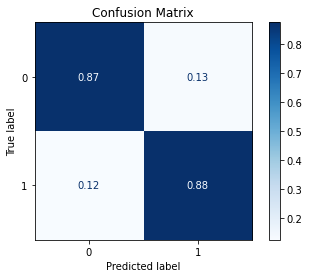

Acuracy: 87.23%

Precision:  0.6980415909549768

Recall:  0.8742893120158737

F1 =  0.7421515183790186

ROC AUC =  0.907124050826115


In [23]:
model = train_model_plot_results(train_x_sel, train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

We can see that the **CatBoostSelection** class managed to improve even further the results obtained with the scaled data, where we have a higher F1 score and a similar ROC AUC. Note that we are now using a lot less data, since we removed several features from the dataset.

## 5 - Synthetic Data

Since we have an imbalanced dataset, we can generate instances of the minority class to improve the balance between the classes. Below, we increase the quantity of minority instances (patients with disease) from 220 to 400.

### imblearn Library

In [24]:
train_y.value_counts()

0    2152
1     220
Name: sick-euthyroid, dtype: int64

In [25]:
rebalance = dp.Rebalance(
				X=train_x_sel,
				y=train_y,
				strategy_over={0:2152, 1:400},
				over_sampler=True,
				under_sampler=False
			)
train_x_res, train_y_res = rebalance.fit_resample()
train_y_res.value_counts()

No columns specified for imputation. These columns have been automatically identified:
[]
Running oversampling...
...finished


0    2152
1     400
Name: sick-euthyroid, dtype: int64

------------
TEST
------------
[[623  95]
 [  8  65]]


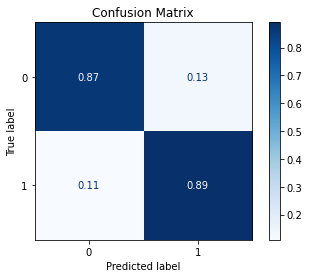

Acuracy: 86.98%

Precision:  0.696785855784469

Recall:  0.8790494905941161

F1 =  0.7407935300985947

ROC AUC =  0.9110542984698745


In [26]:
model = train_model_plot_results(train_x_res, train_y_res, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Notice that the **Rebalance** class managed to slightly improve the ROC AUC compared to the feature selection step, while maintaining a similar F1 score.

### Creating Artificial Data using Deep Learning

#### CTGAN

In [27]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="ctgan",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

syn_train_y.value_counts()

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warning

0    2152
1     420
Name: sick-euthyroid, dtype: int64

------------
TEST
------------
[[577 141]
 [  8  65]]


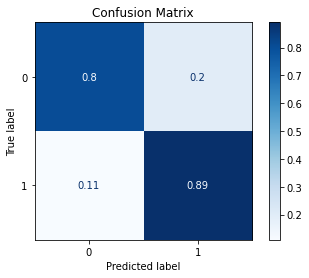

Acuracy: 81.16%

Precision:  0.6509293834536554

Recall:  0.847016064410272

F1 =  0.6757991621210496

ROC AUC =  0.9004846033502498


In [28]:
model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

------------
TEST
------------
[[624  94]
 [ 15  58]]


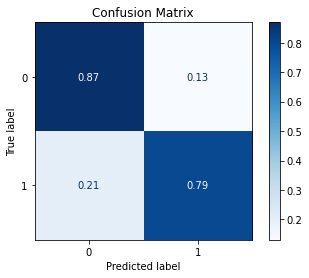

Acuracy: 86.22%

Precision:  0.6790523844823326

Recall:  0.8318006639447475

F1 =  0.7176156554491115

ROC AUC =  0.8991300034341969


In [29]:
conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=600, conditions=conditions)

model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

#### TVAE

Finally, we generate artificial instances using TVAE (a variational auto encoder for generating tabular data).

In [30]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="tvae",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn2_train_x, syn2_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warning

------------
TEST
------------
[[598 120]
 [  9  64]]


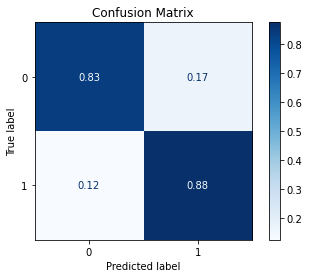

Acuracy: 83.69%

Precision:  0.6664995344173054

Recall:  0.8547907047735337

F1 =  0.7003479920710668

ROC AUC =  0.8958102796962643


In [31]:
model = train_model_plot_results(syn2_train_x, syn2_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)